In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
from pyert.pyert_core.analytic_geometric_factor import analytic_geometric_factor as geom_fact

In [2]:
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics.ert import createERTData
from pygimli.physics.ert import simulate as simulateERT

(-0.25, 5.25, -8.399999999999999, 0.39999999999999997)

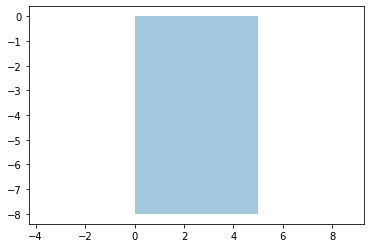

In [51]:
fig, ax = plt.subplots()
patch = Polygon(np.array([[0,0],[5,0], [5,-8],[0,-8]]))
p = PatchCollection([patch], alpha=0.4)
ax.add_collection(p)
ax.set_xlim([-1, 6])
ax.set_ylim([-9, 1])
plt.axis('equal')

In [52]:
poly.createNodeWithCheck?

In [53]:
poly = pg.Mesh(2)

for n in patch.get_verts():
    poly.createNodeWithCheck(n)

for i in range(poly.nodeCount() - 1):
    poly.createEdge(poly.node(i), poly.node(i + 1))

poly.createEdge(poly.node(poly.nodeCount() - 1), poly.node(0))


In [54]:
electrodes = []
for i in np.arange(1., 7., 1.):
    poly.createNodeWithCheck([1., -i])
    electrodes.append([1., -i])
    poly.createNodeWithCheck([4., -i])
    electrodes.append([4., -i])
electrodes = np.array(electrodes)

## Create the mesh

In [59]:
mesh = pg.meshtools.createMesh(poly, area=.125)

In [56]:
x = np.array(mesh.cellCenters())[:,:2]

In [9]:
def material_properties(x):
    rho = np.zeros(x.shape[0])
    cond = x[:,1]>-3.7
    rho[cond] = np.exp(np.random.normal(3.22,.2,len(rho[cond])))
    cond = x[:,1]<=-3.7
    rho[cond] = np.exp(np.random.normal(2.08,.2,len(rho[cond])))
    return rho

(-8.0, 0.0)

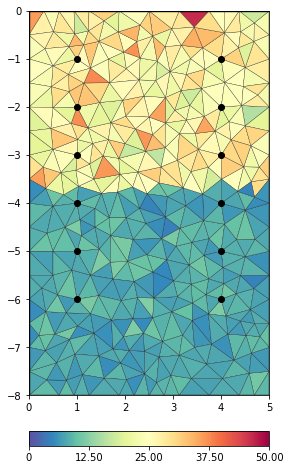

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
pg.show(mesh, material_properties(x), ax=ax, cMap='Spectral_r',
        logScale=False, showLater=True, showMesh=True, colorBar=True, cMin=0., cMax=50.)
ax.plot(electrodes[:,0], electrodes[:,1], 'ok')
ax.set_ylim([-8, 0])

## Create the data container

In [11]:
scheme = pg.DataContainerERT()

In [12]:
elecs = electrodes

In [13]:
scheme.setSensors(elecs)

Create the sequence

In [14]:
seq = np.array([[0, 1, 2, 3],[2, 3, 4, 5],[4, 5, 6, 7],[6, 7, 8, 9],[8, 9, 10, 11], [0, 1, 4, 5],[2, 3, 6, 7],[4, 5, 8, 9],[6, 7, 10, 11]])

In [15]:
seq

array([[ 0,  1,  2,  3],
       [ 2,  3,  4,  5],
       [ 4,  5,  6,  7],
       [ 6,  7,  8,  9],
       [ 8,  9, 10, 11],
       [ 0,  1,  4,  5],
       [ 2,  3,  6,  7],
       [ 4,  5,  8,  9],
       [ 6,  7, 10, 11]])

Specificy electrode positions

In [16]:
pos  = {}
for i in range(len(electrodes)):
    pos.update({i : list(electrodes[i])})
pos

{0: [1.0, -1.0],
 1: [4.0, -1.0],
 2: [1.0, -2.0],
 3: [4.0, -2.0],
 4: [1.0, -3.0],
 5: [4.0, -3.0],
 6: [1.0, -4.0],
 7: [4.0, -4.0],
 8: [1.0, -5.0],
 9: [4.0, -5.0],
 10: [1.0, -6.0],
 11: [4.0, -6.0]}

Convert sequence of electrodes to sequence of positions

In [17]:
pos_seq = []
for s in seq:
    l=[]
    for i in [pos[x] for x in s]:
        j= i.copy()
        j.append(0)
        l.append(j)
    pos_seq.append(l)
pos_seq

[[[1.0, -1.0, 0], [4.0, -1.0, 0], [1.0, -2.0, 0], [4.0, -2.0, 0]],
 [[1.0, -2.0, 0], [4.0, -2.0, 0], [1.0, -3.0, 0], [4.0, -3.0, 0]],
 [[1.0, -3.0, 0], [4.0, -3.0, 0], [1.0, -4.0, 0], [4.0, -4.0, 0]],
 [[1.0, -4.0, 0], [4.0, -4.0, 0], [1.0, -5.0, 0], [4.0, -5.0, 0]],
 [[1.0, -5.0, 0], [4.0, -5.0, 0], [1.0, -6.0, 0], [4.0, -6.0, 0]],
 [[1.0, -1.0, 0], [4.0, -1.0, 0], [1.0, -3.0, 0], [4.0, -3.0, 0]],
 [[1.0, -2.0, 0], [4.0, -2.0, 0], [1.0, -4.0, 0], [4.0, -4.0, 0]],
 [[1.0, -3.0, 0], [4.0, -3.0, 0], [1.0, -5.0, 0], [4.0, -5.0, 0]],
 [[1.0, -4.0, 0], [4.0, -4.0, 0], [1.0, -6.0, 0], [4.0, -6.0, 0]]]

Compute the geometric factors 

In [18]:
k = [geom_fact(np.array(l), np.array([0., 1., 0., 0.])) for l in pos_seq]

Insert sequence into the data container

In [19]:
scheme.resize(len(seq))

In [20]:
scheme.add('a', seq[:,0])
scheme.add('b', seq[:,1])
scheme.add('m', seq[:,2])
scheme.add('n', seq[:,3])
scheme.add('k', k)
scheme.set('valid', np.ones(len(seq)))

Create and display forward mesh

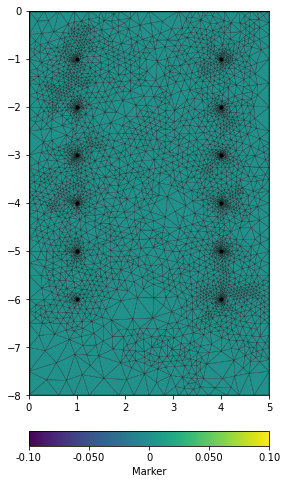

In [21]:
for s in scheme.sensors():
    mesh.createNode(s + [0.0, -0.02])

# Now we can create our forward modeling mesh.
fw_mesh = mt.createMesh(mesh, quality=31)

fig, ax = plt.subplots(figsize=(16, 8))
pg.show(fw_mesh, ax=ax, data=fw_mesh.cellMarkers(), label='Marker', showMesh=True)
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], '.k')

Populate the mesh with resistivites drawn from two distrbutions

In [68]:
x = np.array(fw_mesh.cellCenters())

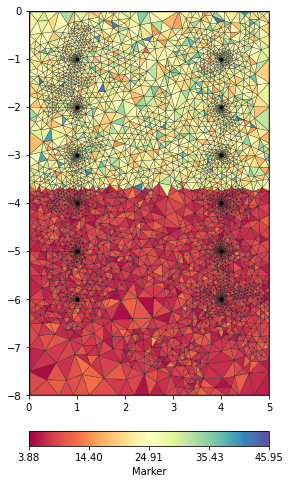

In [24]:
fig, ax = plt.subplots(figsize=(16, 8))
pg.show(fw_mesh, ax=ax, data=material_properties(x), label='Marker', showMesh=True, cMap='Spectral')
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], '.k')

Simulate apparent resistivities

In [25]:
data = simulateERT(fw_mesh, res=material_properties(x), scheme=scheme, verbose=True)

In [26]:
def DataContainerERT_to_df(data_container):
    cols = np.array(data_container.dataMap())[:,0]
    data = np.vstack([data_container.get(i) for i in cols]).T
    df = pd.DataFrame(data=data, columns=cols)
    return df

In [27]:
df = DataContainerERT_to_df(data)

In [28]:
df

,a,b,err,i,ip,iperr,k,m,n,r,rhoa,u,valid
0,0.0,1.0,0.0,0.0,0.0,0.0,8.040899,2.0,3.0,0.0,30.177167,0.0,1.0
1,2.0,3.0,0.0,0.0,0.0,0.0,8.821308,4.0,5.0,0.0,26.279829,0.0,1.0
2,4.0,5.0,0.0,0.0,0.0,0.0,9.036355,6.0,7.0,0.0,14.875522,0.0,1.0
3,6.0,7.0,0.0,0.0,0.0,0.0,9.113011,8.0,9.0,0.0,12.637806,0.0,1.0
4,8.0,9.0,0.0,0.0,0.0,0.0,9.146156,10.0,11.0,0.0,10.631852,0.0,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,23.044884,4.0,5.0,0.0,28.308894,0.0,1.0
6,2.0,3.0,0.0,0.0,0.0,0.0,26.153200,6.0,7.0,0.0,16.452842,0.0,1.0
7,4.0,5.0,0.0,0.0,0.0,0.0,27.246083,8.0,9.0,0.0,16.879855,0.0,1.0
8,6.0,7.0,0.0,0.0,0.0,0.0,27.695424,10.0,11.0,0.0,15.026294,0.0,1.0


Insert an error on the simulated apparent resistivites

In [39]:
df['err'] = 0.03 * df['rhoa']

In [40]:
df

,a,b,err,i,ip,iperr,k,m,n,r,rhoa,u,valid
0,0.0,1.0,0.905315,0.0,0.0,0.0,8.040899,2.0,3.0,0.0,30.177167,0.0,1.0
1,2.0,3.0,0.788395,0.0,0.0,0.0,8.821308,4.0,5.0,0.0,26.279829,0.0,1.0
2,4.0,5.0,0.446266,0.0,0.0,0.0,9.036355,6.0,7.0,0.0,14.875522,0.0,1.0
3,6.0,7.0,0.379134,0.0,0.0,0.0,9.113011,8.0,9.0,0.0,12.637806,0.0,1.0
4,8.0,9.0,0.318956,0.0,0.0,0.0,9.146156,10.0,11.0,0.0,10.631852,0.0,1.0
5,0.0,1.0,0.849267,0.0,0.0,0.0,23.044884,4.0,5.0,0.0,28.308894,0.0,1.0
6,2.0,3.0,0.493585,0.0,0.0,0.0,26.153200,6.0,7.0,0.0,16.452842,0.0,1.0
7,4.0,5.0,0.506396,0.0,0.0,0.0,27.246083,8.0,9.0,0.0,16.879855,0.0,1.0
8,6.0,7.0,0.450789,0.0,0.0,0.0,27.695424,10.0,11.0,0.0,15.026294,0.0,1.0


Update the data container

In [31]:
data.set('err', pg.core.asvector(df['err']))

do not use asvector(ndarray) use ndarray directly .. this method will be removed soon


## Invert the simulated dataset

In [36]:
ert = pg.physics.ERTManager(sr=False, useBert=True, verbose=True, debug=False)

Create on inversion mesh

In [46]:
from pygimli.meshtools import appendTriangleBoundary, merge2Meshes

In [61]:
for cell in mesh.cells():
    cell.setMarker(1)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f434cae8890>,
 <matplotlib.colorbar.Colorbar at 0x7f43508333d0>)

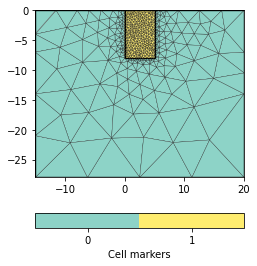

In [63]:
inv_mesh = appendTriangleBoundary(mesh, -20., 20., quality=31, smooth=True,
                              marker=0, isSubSurface=True)

pg.show(inv_mesh, markers=True, showMesh=True)

In [81]:
model = []
phi = []
for lam in np.arange(.1, 10.1, .1):
    model.append(ert.invert(data=data, mesh=inv_mesh, lam=lam))
    phi.append([ert.inv.phiData(), ert.inv.phiModel()])

10/11/20 - 12:22:45 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:22:45 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:22:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:22:45 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:22:45 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:22:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:22:45 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:22:45 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:22:45 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------


10/11/20 - 12:22:46 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:22:46 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:22:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:22:46 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:22:46 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:22:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:22:46 - pyGIMLi - INFO - Starting inversion.


--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 0.01 (dPhi = 26.81%) lam: 0.1


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.01)                   #
################################################################################


10/11/20 - 12:22:46 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:22:46 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:22:47 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:22:47 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:22:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:22:47 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:22:47 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:22:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:22:47 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:22:47 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:22:47 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.02 (dPhi = 16.04%) lam: 0.2


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.02)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:22:49 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:22:49 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:22:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:22:49 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:22:49 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:22:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:22:49 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:22:49 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:22:49 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.03 (dPhi = 11.47%) lam: 0.30000000000000004


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.03)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:22:51 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:22:51 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:22:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:22:51 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:22:51 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:22:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:22:51 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:22:51 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:22:51 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.03 (dPhi = 8.92%) lam: 0.4


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.03)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:22:52 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:22:52 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:22:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:22:52 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:22:52 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:22:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:22:52 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:22:52 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:22:52 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.04 (dPhi = 7.34%) lam: 0.5


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.04)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:22:53 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:22:53 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:22:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:22:53 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:22:53 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:22:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:22:53 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:22:53 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:22:53 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.05 (dPhi = 6.23%) lam: 0.6


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.05)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:22:54 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:22:54 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:22:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:22:54 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:22:54 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:22:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:22:55 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:22:55 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:22:55 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.05 (dPhi = 5.43%) lam: 0.7000000000000001


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.05)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:22:56 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:22:56 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:22:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:22:56 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:22:56 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:22:56 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:22:56 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:22:56 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:22:56 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.06 (dPhi = 4.83%) lam: 0.8


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.06)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:22:57 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:22:57 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:22:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:22:57 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:22:57 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:22:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:22:57 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:22:57 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:22:57 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.06 (dPhi = 4.36%) lam: 0.9


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.06)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:22:59 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:22:59 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:22:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:22:59 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:22:59 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:22:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:22:59 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:22:59 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:22:59 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.07 (dPhi = 3.98%) lam: 1.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.07)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:00 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:00 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:00 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:00 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:00 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:00 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:00 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.08 (dPhi = 3.68%) lam: 1.1


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.08)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------


10/11/20 - 12:23:01 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:01 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:01 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:01 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:01 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:01 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:01 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 0.08 (dPhi = 3.42%) lam: 1.2000000000000002


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.08)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:02 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:02 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:02 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:02 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:02 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:02 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:02 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.08 (dPhi = 3.2%) lam: 1.3000000000000003


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.08)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:04 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:04 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:04 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:04 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:04 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:04 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:04 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.09 (dPhi = 3.01%) lam: 1.4000000000000001


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.09)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------


10/11/20 - 12:23:05 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:05 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:05 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:05 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:05 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:05 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:05 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 0.09 (dPhi = 2.86%) lam: 1.5000000000000002


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.09)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:06 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:06 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:06 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:06 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:06 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:06 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:06 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.1 (dPhi = 2.71%) lam: 1.6


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.10)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:07 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:07 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:07 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:07 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:07 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:07 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:07 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.1 (dPhi = 2.59%) lam: 1.7000000000000002


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.10)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:08 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:08 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:08 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:08 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:08 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:08 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:08 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.11 (dPhi = 2.48%) lam: 1.8000000000000003


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.11)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:09 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:09 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:09 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:09 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:09 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:09 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:09 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.11 (dPhi = 2.38%) lam: 1.9000000000000001


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.11)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:10 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:10 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:10 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:10 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:10 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:10 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:10 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.11 (dPhi = 2.29%) lam: 2.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.11)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:11 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:11 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:11 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:11 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:11 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:11 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:11 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.12 (dPhi = 2.21%) lam: 2.1


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.12)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:12 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:12 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:12 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:12 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:12 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:12 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:12 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.12 (dPhi = 2.15%) lam: 2.2


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.12)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:13 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:13 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:13 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:13 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:13 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:13 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:13 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.12 (dPhi = 2.08%) lam: 2.3000000000000003


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.12)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:14 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:14 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:14 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:14 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:14 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:14 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:14 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.13 (dPhi = 2.02%) lam: 2.4000000000000004


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.13)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:15 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:15 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:15 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:15 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:15 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:15 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:15 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.13 (dPhi = 1.96%) lam: 2.5000000000000004


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.13)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------


10/11/20 - 12:23:16 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:16 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:16 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:16 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:16 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:16 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:16 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 0.13 (dPhi = 1.91%) lam: 2.6


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.13)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:17 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:17 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:17 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:17 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:17 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:17 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:17 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.14 (dPhi = 1.86%) lam: 2.7


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.14)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:18 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:18 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:18 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:18 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:18 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:18 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:18 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.14 (dPhi = 1.82%) lam: 2.8000000000000003


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.14)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:19 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:19 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:19 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:19 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:19 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:19 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:19 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.14 (dPhi = 1.78%) lam: 2.9000000000000004


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.14)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:21 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:21 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:21 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:21 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:21 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:21 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:21 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.14 (dPhi = 1.74%) lam: 3.0000000000000004


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.14)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:22 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:22 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:22 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:22 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:22 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:22 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:22 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.15 (dPhi = 1.7%) lam: 3.1


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.15)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:23 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:23 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:23 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:23 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:23 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:23 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:23 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.15 (dPhi = 1.67%) lam: 3.2


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.15)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:24 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:24 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:24 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:24 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:24 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:24 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:24 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.15 (dPhi = 1.64%) lam: 3.3000000000000003


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.15)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:25 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:25 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:25 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:25 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:25 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:25 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:25 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.16 (dPhi = 1.61%) lam: 3.4000000000000004


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.16)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:26 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:26 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:26 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:26 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:27 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:27 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:27 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.16 (dPhi = 1.58%) lam: 3.5000000000000004


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.16)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:28 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:28 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:28 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:28 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:28 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:28 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:28 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.16 (dPhi = 1.56%) lam: 3.6


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.16)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:30 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:30 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:30 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:30 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:30 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:30 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:30 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.16 (dPhi = 1.53%) lam: 3.7


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.16)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:31 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:31 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:31 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:31 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:31 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:31 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:31 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.16 (dPhi = 1.51%) lam: 3.8000000000000003


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.16)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:32 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:32 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:32 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:32 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:32 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:32 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:32 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.17 (dPhi = 1.48%) lam: 3.9000000000000004


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.17)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:33 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:33 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:33 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:33 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:33 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:33 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:33 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.17 (dPhi = 1.46%) lam: 4.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.17)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:35 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:35 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:35 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:35 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:35 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:35 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:35 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.17 (dPhi = 1.44%) lam: 4.1


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.17)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:36 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:36 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:36 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:36 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:36 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:36 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:36 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.17 (dPhi = 1.42%) lam: 4.2


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.17)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:37 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:37 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:37 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:37 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:37 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:37 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:37 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.18 (dPhi = 1.4%) lam: 4.3


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.18)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:38 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:38 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:38 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:38 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:38 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:38 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:38 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.18 (dPhi = 1.39%) lam: 4.3999999999999995


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.18)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:39 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:39 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:39 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:39 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:40 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:40 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:40 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.18 (dPhi = 1.37%) lam: 4.5


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.18)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:41 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:41 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:41 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:41 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:41 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:41 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:41 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.18 (dPhi = 1.35%) lam: 4.6


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.18)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:42 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:42 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:42 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:42 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:42 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:42 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:42 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.18 (dPhi = 1.33%) lam: 4.7


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.18)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:43 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:43 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:43 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:43 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:43 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:43 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:43 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.18 (dPhi = 1.32%) lam: 4.8


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.18)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:44 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:44 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:44 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:44 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:44 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:44 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:44 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.19 (dPhi = 1.3%) lam: 4.9


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.19)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:45 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:45 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:45 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:45 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:45 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:45 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:45 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.19 (dPhi = 1.29%) lam: 5.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.19)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:46 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:46 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:46 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:46 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:46 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:46 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:46 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.19 (dPhi = 1.28%) lam: 5.1


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.19)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:47 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:47 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:47 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:47 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:47 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:47 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:47 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:47 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:47 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.19 (dPhi = 1.26%) lam: 5.2


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.19)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:49 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:49 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:49 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:49 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:49 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:49 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:49 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.19 (dPhi = 1.25%) lam: 5.3


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.19)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:50 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:50 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:51 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:51 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:51 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:51 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:51 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.19 (dPhi = 1.24%) lam: 5.4


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.19)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:52 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:52 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:52 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:52 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:52 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:52 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:52 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.2 (dPhi = 1.22%) lam: 5.5


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.20)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:53 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:53 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:53 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:53 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:53 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:53 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:53 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.2 (dPhi = 1.21%) lam: 5.6


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.20)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:54 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:54 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:54 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:54 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:54 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:54 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:54 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.2 (dPhi = 1.2%) lam: 5.7


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.20)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:55 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:55 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:55 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:55 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:55 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:55 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:55 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.2 (dPhi = 1.19%) lam: 5.8


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.20)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:56 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:56 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:56 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:56 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:57 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:57 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:57 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.2 (dPhi = 1.18%) lam: 5.9


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.20)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:58 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:58 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:58 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:58 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:58 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:58 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:58 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.2 (dPhi = 1.17%) lam: 6.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.20)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:23:59 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:23:59 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:23:59 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:23:59 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:23:59 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:23:59 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:23:59 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:23:59 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:23:59 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.2 (dPhi = 1.16%) lam: 6.1


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.20)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:00 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:00 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:00 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:00 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:00 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:00 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:00 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.21 (dPhi = 1.15%) lam: 6.2


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.21)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:01 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:01 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:01 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:01 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:01 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:01 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:01 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.21 (dPhi = 1.14%) lam: 6.3


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.21)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:02 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:02 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:02 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:02 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:02 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:02 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:02 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.21 (dPhi = 1.13%) lam: 6.4


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.21)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------


10/11/20 - 12:24:03 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:03 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:03 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:03 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:03 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:03 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:03 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 0.21 (dPhi = 1.12%) lam: 6.5


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.21)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:04 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:04 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:04 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:04 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:05 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:05 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:05 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.21 (dPhi = 1.11%) lam: 6.6


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.21)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:06 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:06 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:06 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:06 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:06 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:06 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:06 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.21 (dPhi = 1.1%) lam: 6.7


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.21)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:07 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:07 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:07 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:07 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:07 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:07 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:07 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.21 (dPhi = 1.09%) lam: 6.8


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.21)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:08 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:08 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:08 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:08 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:08 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:08 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:08 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.21 (dPhi = 1.08%) lam: 6.9


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.21)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:09 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:09 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:09 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:09 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:09 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:09 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:09 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.22 (dPhi = 1.07%) lam: 7.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.22)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:10 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:10 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:10 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:10 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:10 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:10 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:10 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.22 (dPhi = 1.07%) lam: 7.1


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.22)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:11 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:11 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:11 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:11 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:11 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:11 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:11 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.22 (dPhi = 1.06%) lam: 7.2


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.22)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:13 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:13 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:13 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:13 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:13 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:13 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:13 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:13 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.22 (dPhi = 1.05%) lam: 7.3


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.22)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:14 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:14 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:14 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:14 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:14 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:14 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:14 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.22 (dPhi = 1.04%) lam: 7.4


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.22)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:16 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:16 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:16 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:16 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:16 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:16 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:16 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:16 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:16 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.22 (dPhi = 1.03%) lam: 7.5


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.22)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:17 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:17 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:17 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:17 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:17 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:17 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:17 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:17 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:17 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.22 (dPhi = 1.03%) lam: 7.6


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.22)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:18 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:18 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:18 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:18 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:18 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:18 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:18 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:18 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.22 (dPhi = 1.02%) lam: 7.7


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.22)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:20 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:20 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:20 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:20 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:20 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:20 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:20 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.22 (dPhi = 1.01%) lam: 7.8


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.22)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:21 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:21 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:21 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:21 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:21 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:21 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:21 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.22 (dPhi = 1.01%) lam: 7.9


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.22)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:22 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:22 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:22 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:22 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:22 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:22 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:22 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.23 (dPhi = 1.0%) lam: 8.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.23)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:24 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:24 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:24 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:24 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:24 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:24 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:24 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.23 (dPhi = 0.99%) lam: 8.1


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.23)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:26 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:26 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:26 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:26 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:26 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:26 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:26 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.23 (dPhi = 0.98%) lam: 8.2


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.23)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:28 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:28 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:28 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:28 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:28 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:28 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:28 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.23 (dPhi = 0.98%) lam: 8.3


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.23)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:29 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:29 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:29 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:29 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:29 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:29 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:29 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.23 (dPhi = 0.97%) lam: 8.4


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.23)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:30 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:30 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:30 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:30 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:30 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:30 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:30 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.23 (dPhi = 0.96%) lam: 8.5


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.23)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:31 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:31 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:31 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:31 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:31 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:31 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:31 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.23 (dPhi = 0.96%) lam: 8.6


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.23)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:33 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:33 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:33 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:33 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:33 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:33 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:33 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.23 (dPhi = 0.95%) lam: 8.7


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.23)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:34 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:34 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:34 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:34 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:34 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:34 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:34 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.23 (dPhi = 0.94%) lam: 8.8


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.23)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:35 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:35 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:35 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:35 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:35 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:35 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:35 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.23 (dPhi = 0.94%) lam: 8.9


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.23)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:36 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:36 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:36 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:36 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:36 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:36 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:36 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.23 (dPhi = 0.93%) lam: 9.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.23)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:37 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:37 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:37 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:37 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:37 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:37 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:37 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.23 (dPhi = 0.93%) lam: 9.1


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.23)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:39 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:39 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:39 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:39 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:39 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:39 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:39 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.24 (dPhi = 0.92%) lam: 9.2


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.24)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:40 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:40 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:40 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:40 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:40 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:40 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:40 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.24 (dPhi = 0.91%) lam: 9.3


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.24)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:41 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:41 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:41 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:41 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:41 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:41 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:41 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.24 (dPhi = 0.91%) lam: 9.4


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.24)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:43 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:43 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:43 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:43 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:43 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:43 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:43 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.24 (dPhi = 0.9%) lam: 9.5


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.24)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:44 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:44 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:44 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:44 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:44 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:44 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:44 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.24 (dPhi = 0.9%) lam: 9.6


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.24)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:45 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:45 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:45 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:45 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:45 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:45 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:45 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.24 (dPhi = 0.89%) lam: 9.700000000000001


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.24)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:46 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:46 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:46 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:46 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:47 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:47 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:47 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.24 (dPhi = 0.89%) lam: 9.8


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.24)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

10/11/20 - 12:24:48 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:24:48 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:24:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:24:48 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:24:48 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:24:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:24:48 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:24:48 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:24:48 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


chi² = 0.24 (dPhi = 0.88%) lam: 9.9


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.24)                   #
################################################################################
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 0.24 (dPhi = 0.88%) lam: 10.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.24)                   #
#############

In [86]:
phi = np.array(phi)

Text(0.5, 0, 'model misfit')

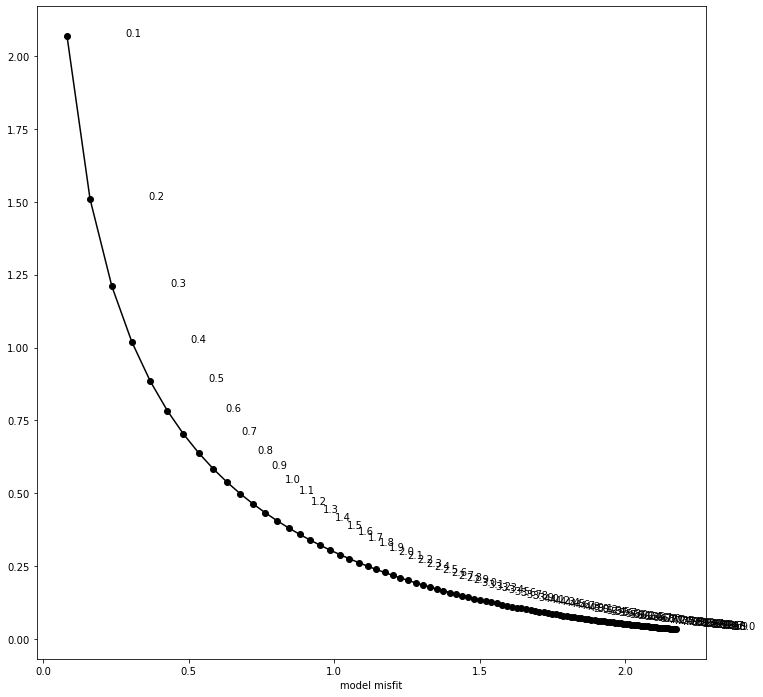

In [92]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(phi[:,0], phi[:,1], '-k')
ax.plot(phi[:,0], phi[:,1], 'ok')
lams = np.arange(.1, 10.1, .1)
for i in range(len(lams)):
    ax.text(phi[i,0]+0.2, phi[i,1], f'{lams[i]:.1f}')
ax.set_xlabel('data misfit')
ax.set_xlabel('model misfit')

In [93]:
model = ert.invert(data=data, mesh=inv_mesh, lam=.85)
chi2 = ert.inv.chi2()
print(f'Khi-2: {chi2}')

10/11/20 - 12:30:22 - pyGIMLi - INFO - Found 2 regions.
10/11/20 - 12:30:22 - pyGIMLi - INFO - Region with smallest marker (0) set to background
10/11/20 - 12:30:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/20 - 12:30:22 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
10/11/20 - 12:30:22 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
10/11/20 - 12:30:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/20 - 12:30:22 - pyGIMLi - INFO - Starting inversion.
10/11/20 - 12:30:22 - pyGIMLi - INFO - Set default startmodel to median(data values)=16.45284187785392
10/11/20 - 12:30:22 - pyGIMLi - INFO - Created startmodel from forward operator: 513 [16.45284187785392,...,16.45284187785392]


fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f4346096930>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f43460969b0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f43460967b0>
min/max (data): 10.63/30.18
min/max (error): 31.90%/90.53%
min/max (start model): 16.45/16.45
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 0.06 (dPhi = 4.58%) lam: 0.85


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.06)                   #
################################################################################
Khi-2: 0.06214336050872512


(<matplotlib.axes._subplots.AxesSubplot at 0x7f4308bb2650>,
 <matplotlib.colorbar.Colorbar at 0x7f4308b535d0>)

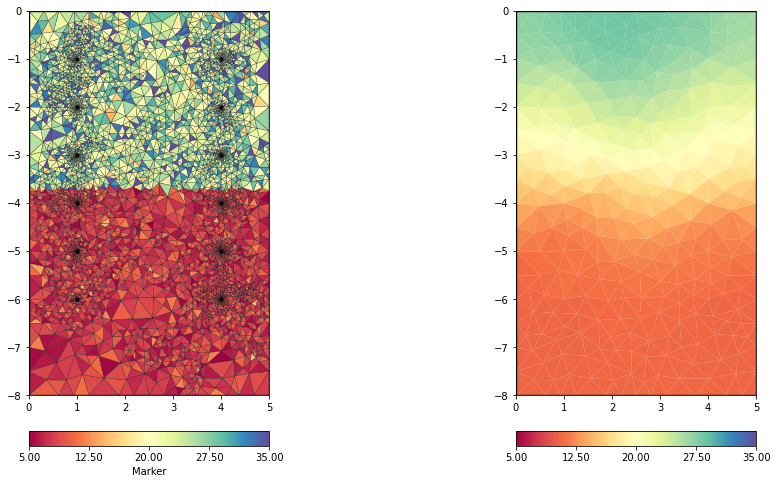

In [95]:
fig, _ = plt.subplots(figsize=(16, 8))
ax1 = plt.subplot(121)
pg.show(fw_mesh, ax=ax1, data=material_properties(x), label='Marker', showMesh=True, cMap='Spectral', cMin=5., cMax=35.)
ax1.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], '.k')
ax2 = plt.subplot(122)
pg.show(ert.paraDomain, data = ert.paraModel(), ax=ax2, cMap='Spectral', cMin=5., cMax=35.)